In [1]:
import numpy as np
import pandas as pd
from numba import jit
import time
import scipy as sp
from scipy import interpolate, integrate
import matplotlib.pyplot as plt
from itertools import product
from walker import WalkerRandomSampling

plt.style.use('fast')
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize']=(8,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'errorbar.capsize': 2})
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Serif']

**This code is owned and was written by Mayura Balakrishnan (bmayura@umich.edu). Please contact me with any questions, and feel free to reach out if you want a deeper explanation or some help.**


# Setting Things Up

The following cell loads the BH and SNR catalogs in. We eliminated Cir X-1/3A 1516-569, W63/W63 X-1, and W50/SS433 from the SNR distributions because those overlaps are not coincidental.

In [2]:
#just loading things in

#from the SNR catalog
SNR_cat = pd.read_csv("SNR_catalog.csv", skiprows=3, header=None)
SNR_cat.columns = ["l", "b", "RA", "Dec", "size", "type", "1-GHz flux", "spectral index", "other names", 'height', 'width', '1-GHz_forcode', 'type_for_code']

#dropping our SNR
SNR_cat = SNR_cat.drop(274, axis=0) #our remnant!
SNR_cat.index = range(len(SNR_cat))

#SNR ls and bs, for height and width, converting it to degrees
SNR_ls, SNR_bs = SNR_cat["l"], SNR_cat["b"]
SNR_heights, SNR_width = SNR_cat['height']*0.0166667, SNR_cat['width']*0.0166667

#creating SNR 'boxes'
SNR_widths = []
for i in range(len(SNR_heights)):
    if (pd.isnull(SNR_width[i]) == True):
        SNR_widths.append(SNR_heights[i])
    else:
        SNR_widths.append(SNR_width[i])
SNR_widths = np.array(SNR_widths)

#just for formatting SNR distance arrays
def fix(pandas_arr):
    new = []
    for i in range(len(pandas_arr)):
        new.append(pandas_arr.to_numpy()[i][0])
    return new

#distances to all populations
SNR_dists = fix(pd.read_csv("SNR_dist_table.csv", usecols=[4])) #kpc

#loading BH catalog
just_BHs = pd.read_csv("just_BHs.csv")
BH_ls = just_BHs['ℓ'].dropna().values
BH_bs = just_BHs.iloc[:,5].dropna().values
BH_dists = just_BHs['d_code'].dropna().values

In the next cell, I try to show code I used to figure out 'num_samps_x' for all the different parameter distributions I'm dealing with: BH latitude, longitude, distance, and SNR galactic latitude, longitude, height, width, and distance. This part is basically trial and error.

In [3]:
'''
used this function to get the number of samples needed for each parameter (LMXB l, LMXB b, etc)
that would return, on average, the number of that population in the milky way
'''

def num_samples_needed(low_range, up_range, distribution, total_MW_num, stepsize, sim_run_num):
    #array to step through
    input_nums = np.arange(low_range,up_range,stepsize)
    peak_of_dist = []
    #stepping through the array
    for input_num in input_nums:
        sim_runs = 0
        num_resulting_samples = []
        while sim_runs < sim_run_num:
            num_resulting_samples.append(len(rejection_sampling(simple_smoothing(distribution), input_num)))
            sim_runs += 1
        #collecting the peak of the distribution each time
        peak_of_dist.append(np.median(num_resulting_samples))
    peak_of_dist = np.array(peak_of_dist) 
    return input_nums[np.argmin(np.abs(peak_of_dist - total_MW_num))]

# then used code that was like this, but I tweaked the bounds and decreased the increments and stuff to get the 
# right numbers, for each population

# print(num_samples_needed(7000, 7100, SNR_bs, len(SNR_bs), 1, 50))
# print(num_samples_needed(1504, 1508, SNR_ls, len(SNR_ls), 1, 50))
# print(num_samples_needed(3425, 3435, SNR_heights, len(SNR_heights), 2, 50))
# print(num_samples_needed(3425, 3435, SNR_widths, len(SNR_sizes), 2, 50))
# print(num_samples_needed(3528, 3535, SNR_dists, len(SNR_ls), 1, 50))
# print(num_samples_needed(705,715, BH_bs, len(BH_bs), 1, 50))
# print(num_samples_needed(1465,1475, BH_ls, len(BH_ls), 2, 50))
# print(num_samples_needed(580,620, BH_dists, len(BH_ls), 10, 20))
# print(num_samples_needed(586,596, BH_dists, len(BH_ls), 1, 50))

# which resulted in the following:
# which is accurate to a factor of ~2 ish, it's hard to be consistent when it comes to statistical variation

'''
XRB and SNR factor add factors to the number of objects simulated each time, in each galaxy.
'''
BH_factor = 1
SNR_factor = 1

'''
now the actual number of samples, calculated using trial and error and the above num_samples_needed function
'''

numsamps_SNR_ls, numsamps_SNR_bs = 1506*SNR_factor, 7005*SNR_factor
numsamps_SNR_heights, numsamps_SNR_widths, numsamps_SNR_dists = 4329*SNR_factor, 3429*SNR_factor, 3531*SNR_factor
numsamps_BH_ls, numsamps_BH_bs = 1473*BH_factor,712*BH_factor
numsamps_BH_dists = 594*BH_factor


Is there a way to do that more efficiently? Probably.

Now we define some functions to smooth a jagged distribution (simple_smoothing) and to run rejection sampling. The rejection sampling code just makes a grid of values and all values under a probability distribution get 'accepted'. A histogram of the sampled values then is very similar to the original histogram.

In [4]:
# this function takes a histogram and uses the bin centers and interpolating to create a smoothed distribution function
def simple_smoothing(rough_dist):
    """
    Returns continuous x-values and a function object that represents the smoothed distribution.
    Parameters
    ----------
    rough_dist : array
        1D original array for smoothing
        
    Returns
    -------
    output : 2 arrays
        more continuous x-values and function object where an input array of x-values will return the smoothed distribution
    """
    n,x,_ = plt.hist(rough_dist, bins = 125)
    plt.clf()
    bin_centers = 0.5*(x[1:]+x[:-1])
    p = interpolate.interp1d(bin_centers, n, fill_value='extrapolate')
    newx = np.linspace(np.min(rough_dist), np.max(rough_dist), 100)
    return newx, p(newx)

# this code takes an initial grid, 'overlays' the probability distribution, and returns the variables that fall within the distribution. Monte carlo rejection sampling
def rejection_sampling(xy, size):
    """
    Returns a new array of values that will have a very similar probability function to the original set of values.

    Parameters
    ----------
    xy : 2-D array of x- and y- values (from simple_smoothing function)
    size : length of grid of values to input
        
    Returns
    -------
    output : array
        simulated distribution
    """
    x, y = xy[0], xy[1]
    xs = np.random.uniform(np.min(x), np.max(x), size)
    ys = np.random.uniform(np.min(y), np.max(y), size)
    p = interpolate.interp1d(x, y)
    variables = xs[ys <= p(xs)]
    return variables

#making smoothed distributions for everything
smoothed_SNR_ls, smoothed_SNR_bs = simple_smoothing(SNR_ls), simple_smoothing(SNR_bs)
smoothed_SNR_heights, smoothed_SNR_widths = simple_smoothing(SNR_heights), simple_smoothing(SNR_widths)
smoothed_BH_bs, smoothed_BH_ls = simple_smoothing(BH_bs),simple_smoothing(BH_ls)

smoothed_SNR_dists = simple_smoothing(SNR_dists)
smoothed_BH_dists = simple_smoothing(BH_dists)


<Figure size 800x800 with 0 Axes>

In [5]:
'''
The next three functions just trim arrays. They take in x number of arrays and return versions
of all the arrays that are cut to the length of the shortest input array. This is because the rejection sampling
returns a different number of samples each time.
'''
 
def trim2(arr1, arr2):
    m = min(len(arr1), len(arr2))
    a,b= arr1[:m], arr2[:m]
    return a,b

def trim3(arr1, arr2, arr3): 
    m = min(len(arr1), len(arr2))
    n = min(len(arr3), m)
    a,b,c = arr1[:n], arr2[:n], arr3[:n]
    return a,b,c

def trim4(arr1, arr2, arr3, arr4):
    m = min(len(arr1), len(arr2))
    n = min(len(arr3), len(arr4))
    mn = min(m, n)
    a,b,c,d = arr1[:mn], arr2[:mn], arr3[:mn], arr4[:mn]
    return a,b,c,d

def trim5(arr1, arr2, arr3, arr4, arr5):
    m = min(len(arr1), len(arr2))
    n = min(len(arr3), len(arr4))
    o = len(arr5)
    mn = min(m, n)
    mno = min(mn, o)
    a,b,c,d,e = arr1[:mno], arr2[:mno], arr3[:mno], arr4[:mno], arr5[:mno]
    return a,b,c,d,e

In [6]:
'''
The following chunk of code creates the distribution from which to sample the SNR l values and sizes.
We found that the SNR l values and sizes are in no way independent, as the large remnants tend to be toward the 
galactic anti-center. Using the Walker alias method allows us to sample from the joint supernova remnant galactic
longitude and size distribution. Here we create the 'wrand' variable and that is what we use to simulate new
SNR populations.
'''
# for SNR heights
num=100 #this is an arbitrary number really
h = np.histogram2d(SNR_heights, SNR_ls, bins=num)[0] #this creates the joint distribution
y = np.linspace(np.min(SNR_ls),np.max(SNR_ls), num)
x = np.linspace(np.min(SNR_heights),np.max(SNR_heights),num)
values = h.flatten()
keys = list(product(x, y))
values = h.flatten()
wrand_height_l = WalkerRandomSampling(weights=values, keys=keys) #this creates the variable we will use later

# for SNR widths
y = np.linspace(np.min(SNR_widths),np.max(SNR_widths), num)
x = np.linspace(np.min(SNR_heights),np.max(SNR_heights),num)
values = h.flatten()
keys = list(product(x, y))
values = h.flatten()
wrand_width_height = WalkerRandomSampling(weights=values, keys=keys) #this creates the variable we will use later

In [7]:
''' This function is great for getting a confidence interval for very skewed distributions, like we will have later.'''
def hpd(trace, mass_frac) :
    """
    Returns highest probability density region given by
    a set of samples. (Taken from Paul Draghis)

    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, massfrac = 0.95 gives a
        95% HPD.
        
    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)
    
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    
    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])


In [8]:
'''
Important parameters that will need to get set when running galaxies later: 

- d (d=2 means an overlap is XRB/BH falls anywhere within SNR, 
d=4 means an overlap if XRB/BH is within central half)

- dist_BH_low, dist_BH_high refer to the lower and upper bounds of the distance to the BH
- dist_SNR refers to the minimum distance the SNR must be, which we have found in our paper to be 7.5 kpc
'''

def count_overlaps(SNRs, BHs):
    """
    Returns number of overlaps, given populations of SNRs and BHs. Does not take into account distance.

    Parameters
    ----------
    parameter arrays for SNRs (SNR_l, b, size) and BHs (l,b)
    
        
    Returns
    -------
    output : number of spatial overlaps between BH and SNR 
    """
    #initialising 
    BH_overlaps = 0
    
    #unpacking
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = SNRs 
    sim_BH_ls, sim_BH_bs = BHs
    # for each SNR...
    for i in range(len(sim_SNR_ls)):
        #for each BH...
        for l in range(len(sim_BH_ls)):
            # if the galactic latitude and longitude fit within the SNR (or half of it), then there's an overlap
            if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_BH_ls[l] < sim_SNR_ls[i] + sim_SNR_widths[i]/d:
                if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_BH_bs[l] < sim_SNR_bs[i] + sim_SNR_heights[i]/d:
                    BH_overlaps += 1
                    
    return BH_overlaps
 
def simulate_populations():
    """
    Returns simulated populations of SNRs and BHs.
    Parameters
    ----------
    input: nothing
    
        
    Returns
    -------
    output : population of SNRs and BHs with parameters that match MW distributions
    """
    sim_SNR_ls = rejection_sampling(smoothed_SNR_ls, numsamps_SNR_ls)
    sim_SNR_bs = rejection_sampling(smoothed_SNR_bs, numsamps_SNR_bs)
    sim_SNR_heights = rejection_sampling(smoothed_SNR_heights, numsamps_SNR_heights)
    sim_SNR_widths = rejection_sampling(smoothed_SNR_widths, numsamps_SNR_widths)
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)
    
    '''
    this next chunk of code accounts for the fact that the sizes of SNRs is connected to galactic longitude
    bigger remnants are more easily seen towards galactic anti-center.
    Using the galactic wrand variable which contains information for the galactic SNR_ls and SNR_sizes,
    '''
    samples_hl = wrand_height_l.random(len(sim_SNR_bs))
    sim_SNR_ls, sim_SNR_heights = samples_hl[:,1], samples_hl[:,0]
    
    samples_hw = wrand_width_height.random(len(sim_SNR_heights))
    sim_SNR_widths = samples_hw[:,0]
    
    sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
    sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)

    #trimming arrays so arrays within a population are all the same length
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)
    sim_BH_ls, sim_BH_bs = trim2(sim_BH_ls, sim_BH_bs)
    
    SNRs = sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths
    BHs = sim_BH_ls, sim_BH_bs
    return SNRs, BHs


# this function counts overlaps and takes into account a distance constraint
def count_overlaps_withdist(SNRs, BHs):
    '''
    Same as above count_overlaps function but takes into account distance.
    Here we say that the SNR has to be further than dist_SNR (kpc) away and the BH has to be between
    dist_BH_low < BH distance < dist_BH_high
    '''
    BH_overlaps = 0
    
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = SNRs 
    sim_BH_ls, sim_BH_bs, sim_BH_dists = BHs
    

    for i in range(len(sim_SNR_ls)):
        #if SNR is further than dist_SNR
        if sim_SNR_dists[i] > dist_SNR:
            #how many BHs overlap?
            for l in range(len(sim_BH_ls)):
                if sim_SNR_ls[i]-sim_SNR_widths[i]/d < sim_BH_ls[l] < sim_SNR_ls[i] + sim_SNR_widths[i]/d:
                    if sim_SNR_bs[i]-sim_SNR_heights[i]/d < sim_BH_bs[l] < sim_SNR_bs[i] + sim_SNR_heights[i]/d:
                        # if BH is within distance bounds
                        if dist_BH_low < sim_BH_dists[l] < dist_BH_high:
                            BH_overlaps += 1
                        
    return BH_overlaps

def simulate_populations_withdist():
    '''
    Same as above simulate_populations function generates distance arrays for everything as well.
    '''
    sim_SNR_ls = rejection_sampling(smoothed_SNR_ls, numsamps_SNR_ls)
    sim_SNR_bs = rejection_sampling(smoothed_SNR_bs, numsamps_SNR_bs)
    sim_SNR_heights = rejection_sampling(smoothed_SNR_heights, numsamps_SNR_heights)
    sim_SNR_widths = rejection_sampling(smoothed_SNR_widths, numsamps_SNR_widths)
    
    sim_SNR_dists = rejection_sampling(smoothed_SNR_dists, numsamps_SNR_dists)
    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)
    
    samples_hl = wrand_height_l.random(len(sim_SNR_bs))
    sim_SNR_ls, sim_SNR_heights = samples_hl[:,1], samples_hl[:,0]
    
    samples_hw = wrand_width_height.random(len(sim_SNR_heights))
    sim_SNR_widths = samples_hw[:,0]

    sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
    sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)

    sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
    sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)
    sim_BH_dists = rejection_sampling(smoothed_BH_dists, numsamps_BH_dists)

    sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = trim5(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths,sim_SNR_dists)
    sim_BH_ls, sim_BH_bs, sim_BH_dists = trim3(sim_BH_ls, sim_BH_bs,sim_BH_dists)
    
    SNRs = sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths,sim_SNR_dists
    BHs = sim_BH_ls, sim_BH_bs,sim_BH_dists
    return SNRs, BHs

# Testing

In the following blocks, I simulate a galaxy and plot the simulated parameters (purple) and the original parameters (orange) to show that this procedure accurately reproduces Milky-Way like distributions for BH latitude, longitude, distance, and SNR galactic latitude, longitude, height, width, and distance.

In [9]:
from walker import WalkerRandomSampling
from itertools import *

#this and the next cell is just to show how the simulating works
sim_SNR_ls = rejection_sampling(smoothed_SNR_ls, numsamps_SNR_ls)
sim_SNR_bs = rejection_sampling(smoothed_SNR_bs, numsamps_SNR_bs)
sim_SNR_heights = rejection_sampling(smoothed_SNR_heights, numsamps_SNR_heights)
sim_SNR_widths = rejection_sampling(smoothed_SNR_widths, numsamps_SNR_widths)

sim_SNR_dists = rejection_sampling(smoothed_SNR_dists, numsamps_SNR_dists)
sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths = trim4(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths)


samples_hl = wrand_height_l.random(len(sim_SNR_bs))
sim_SNR_ls, sim_SNR_heights = samples_hl[:,1], samples_hl[:,0]

samples_hw = wrand_width_height.random(len(sim_SNR_heights))
sim_SNR_widths = samples_hw[:,0]

sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)

sim_BH_ls = rejection_sampling(smoothed_BH_ls, numsamps_BH_ls)
sim_BH_bs = rejection_sampling(smoothed_BH_bs, numsamps_BH_bs)
sim_BH_dists = rejection_sampling(smoothed_BH_dists, numsamps_BH_dists)

sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths, sim_SNR_dists = trim5(sim_SNR_ls, sim_SNR_bs, sim_SNR_heights, sim_SNR_widths,sim_SNR_dists)
sim_BH_ls, sim_BH_bs, sim_BH_dists = trim3(sim_BH_ls, sim_BH_bs,sim_BH_dists)


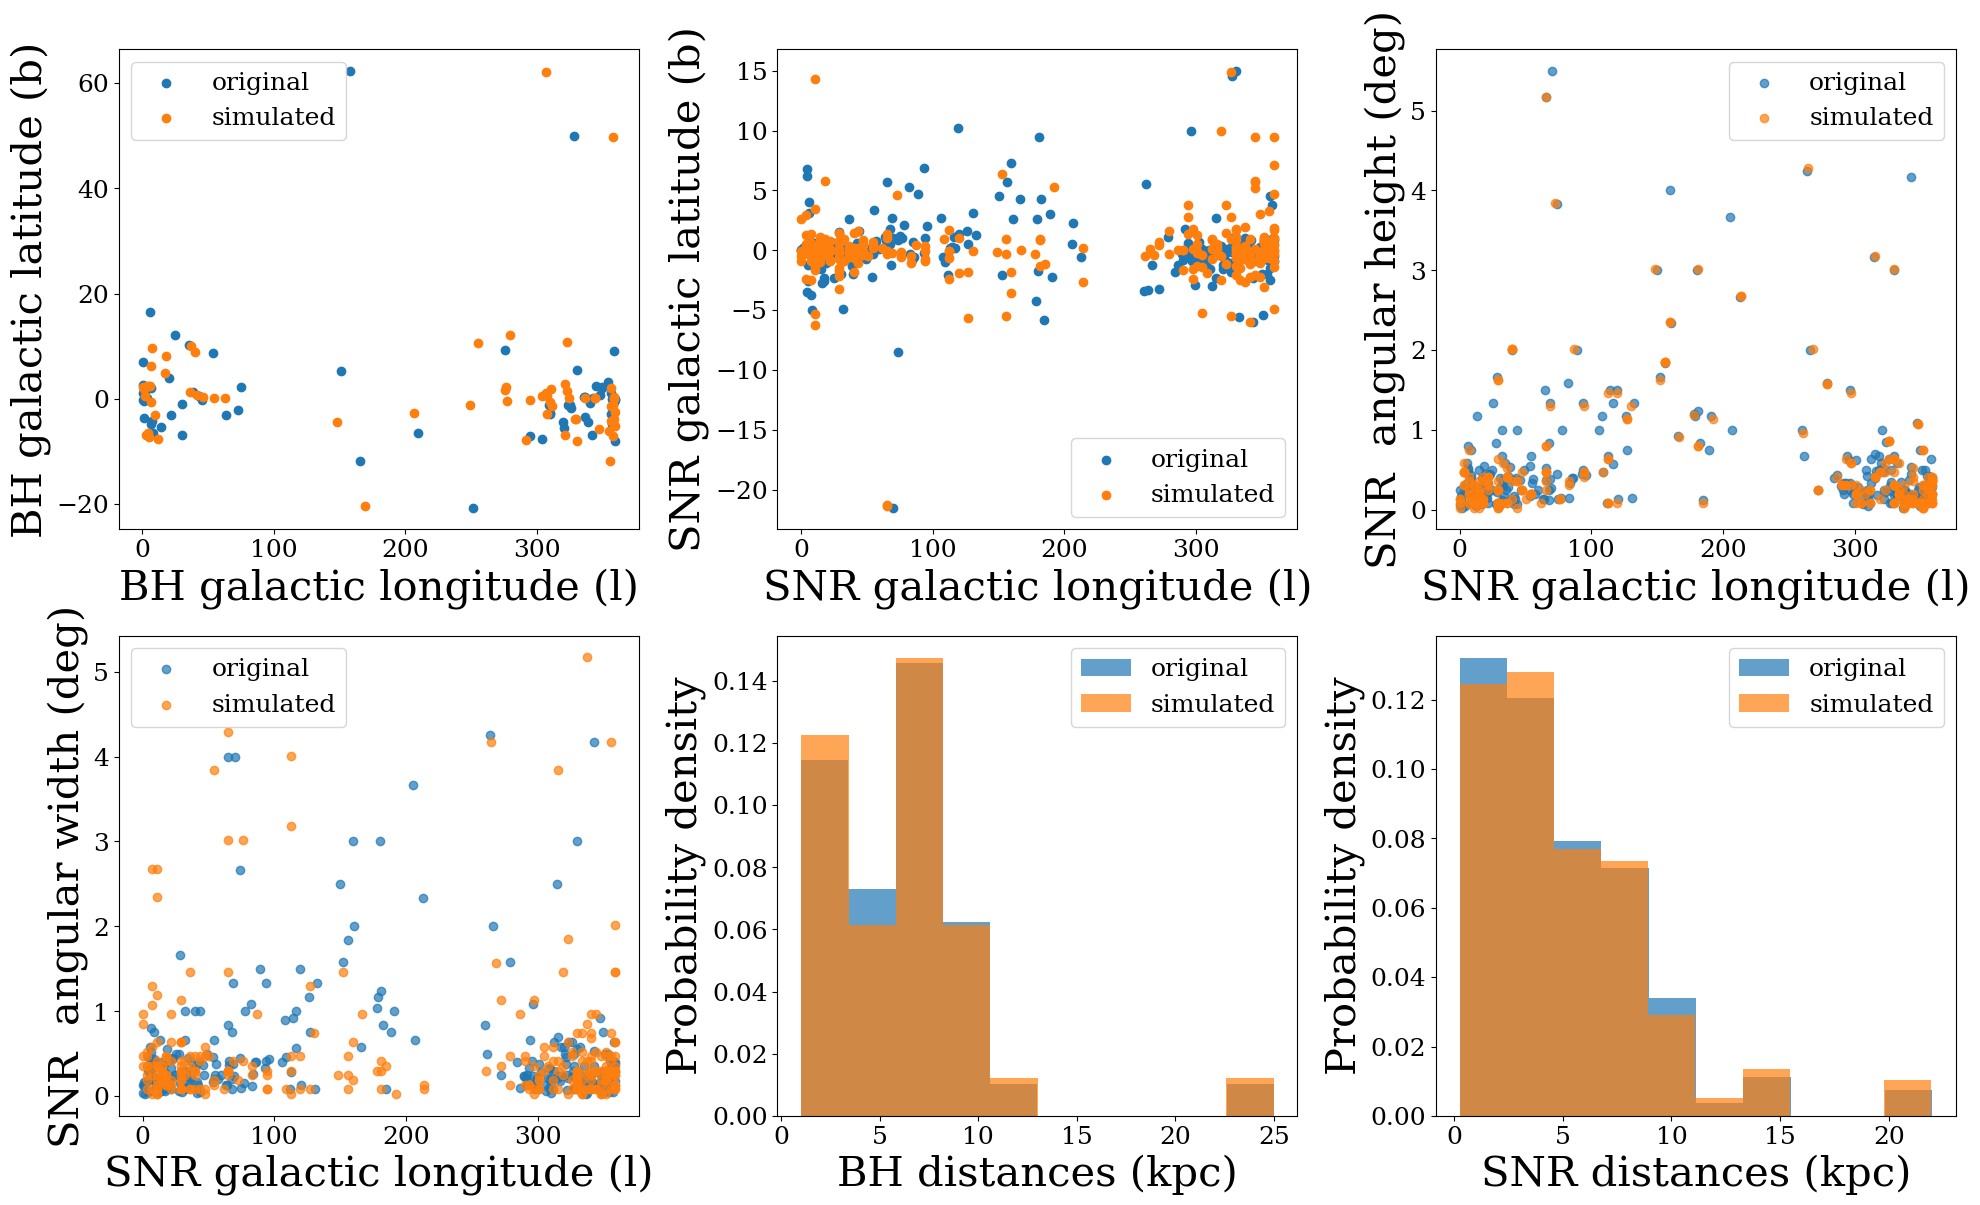

In [10]:
#plotting
fig, ax = plt.subplots(2,3, figsize=[20,12])
((ax1,ax2,ax3),(ax4,ax5,ax6)) = ax

ax1.scatter(BH_ls, BH_bs, label='original')
ax1.scatter(sim_BH_ls, sim_BH_bs, label='simulated')
ax1.set_xlabel("BH galactic longitude (l)", fontsize=30)
ax1.set_ylabel("BH galactic latitude (b)", fontsize=30)


ax2.scatter(SNR_ls, SNR_bs, label='original')
ax2.scatter(sim_SNR_ls, sim_SNR_bs, label='simulated')
ax2.set_ylabel("SNR galactic latitude (b)", fontsize=30)
ax2.set_xlabel("SNR galactic longitude (l)", fontsize=30)


ax3.scatter(SNR_ls, SNR_heights, alpha=0.7, label='original')
ax3.scatter(sim_SNR_ls, sim_SNR_heights, alpha=0.7, label='simulated')
ax3.set_ylabel("SNR  angular height (deg)", fontsize=30)
ax3.set_xlabel("SNR galactic longitude (l)", fontsize=30)

ax4.scatter(SNR_ls, SNR_widths, alpha=0.7, label='original')
ax4.scatter(sim_SNR_ls, sim_SNR_widths, alpha=0.7, label='simulated')
ax4.set_ylabel("SNR  angular width (deg)", fontsize=30)
ax4.set_xlabel("SNR galactic longitude (l)", fontsize=30)

ax5.hist(BH_dists,density=True, alpha=0.7, label='original')
ax5.hist(sim_BH_dists,density=True, alpha=0.7, label='simulated')
ax5.set_xlabel("BH distances (kpc)", fontsize=30)
ax5.set_ylabel("Probability density", fontsize=30)


ax6.hist(SNR_dists, density=True, alpha=0.7, label='original')
ax6.hist(sim_SNR_dists, density=True, alpha=0.7, label='simulated')
ax6.set_xlabel("SNR distances (kpc)", fontsize=30)
ax6.set_ylabel("Probability density", fontsize=30)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.legend()
plt.tight_layout()

So we can see that the simulation reproduces MW distributions pretty well.

# Running the simulation

Now we actually run things. Simulating 100 galaxies to demonstrate.

In [11]:
''' 
d=4 means an overlap only occurs if the BH is in the central half of the remnant 
'''
d = 4

num_galaxies = 1000 #number of galaxies to simulate

#initializing
run_nums = 0
start = time.time()
bh_overlaps_nodist, SNR_count_nodist, BH_count_nodist = [],[],[]

'''
The number of runs here means indicates the number of Milky Way-like galaxies being sampled. In the paper,
we simulate 10,000.

In each galaxy we simulate a population and calculate the number of overlaps. We append the 
number of overlaps to our bh_overlap array.
'''
while run_nums < num_galaxies:
    SNRs, BHs = simulate_populations() #simulate a MW-like population
    bh_overlaps_nodist.append(count_overlaps(SNRs, BHs))#counting the overlaps in that population and recording it
    SNR_count_nodist.append(len(SNRs[0])) #recording number of SNRs generated
    BH_count_nodist.append(len(BHs[0])) #recording number of BHs generated
    
    #the code below just lets us keep track of how many runs the code has run
    if (run_nums%200) == 0:
        print("Simulated %.0i SNRs and %.0i BHs." % (len(SNRs[0]), len(BHs[0])) )
        print("Done with "+str(run_nums)+" rounds")
        print("So far time is", time.time()-start)
        print(" ")
    run_nums += 1
print("Total time taken is (in seconds):", time.time()-start)
bh_overlaps_nodist, SNR_count_nodist, BH_count_nodist= np.array(bh_overlaps_nodist), np.array(SNR_count_nodist), np.array(BH_count_nodist)


Simulated 287 SNRs and 63 BHs.
Done with 0 rounds
So far time is 0.017180204391479492
 
Simulated 267 SNRs and 56 BHs.
Done with 200 rounds
So far time is 3.302842140197754
 
Simulated 267 SNRs and 63 BHs.
Done with 400 rounds
So far time is 6.324660062789917
 
Simulated 273 SNRs and 58 BHs.
Done with 600 rounds
So far time is 9.60167121887207
 
Simulated 289 SNRs and 68 BHs.
Done with 800 rounds
So far time is 12.804710149765015
 
Total time taken is (in seconds): 15.979420185089111


In [12]:
''' 
d=4 means an overlap only occurs if the BH is in the central half of the remnant 
'''
d = 4

dist_BH_low, dist_BH_high = 7.6,9.2
dist_SNR = 7.5
num_galaxies = 1000 #number of galaxies to simulate

#initializing
run_nums = 0
start = time.time()
bh_overlaps, SNR_count, BH_count = [], [], []

'''
The number of runs here means indicates the number of Milky Way-like galaxies being sampled. In the paper,
we simulate 10,000.

In each galaxy we simulate a population and calculate the number of overlaps. We append the 
number of overlaps to our bh_overlap array.
'''
while run_nums < num_galaxies:
    SNRs, BHs = simulate_populations_withdist() #simulating a population
    bh_overlaps.append(count_overlaps_withdist(SNRs, BHs)) #counting the overlaps in that population and recording it
    SNR_count.append(len(SNRs[0])) #recording number of SNRs generated
    BH_count.append(len(BHs[0])) #recording number of BHs generated

    #the code below just lets us keep track of how many runs the code has run
    if (run_nums%200) == 0:
        print("Simulated %.0i SNRs and %.0i BHs." % (len(SNRs[0]), len(BHs[0])) )
        print("Done with "+str(run_nums)+" rounds")
        print("So far time is", time.time()-start)
        print(" ")
    run_nums += 1
print("Total time taken is (in seconds):", time.time()-start)

bh_overlaps, SNR_count, BH_count = np.array(bh_overlaps), np.array(SNR_count), np.array(BH_count)


Simulated 266 SNRs and 57 BHs.
Done with 0 rounds
So far time is 0.009708166122436523
 
Simulated 292 SNRs and 64 BHs.
Done with 200 rounds
So far time is 1.2391481399536133
 
Simulated 288 SNRs and 62 BHs.
Done with 400 rounds
So far time is 2.567124128341675
 
Simulated 281 SNRs and 64 BHs.
Done with 600 rounds
So far time is 3.7465779781341553
 
Simulated 282 SNRs and 60 BHs.
Done with 800 rounds
So far time is 4.87209415435791
 
Total time taken is (in seconds): 5.983597040176392


The simulation outputs the number of overlaps per galaxy, the number of BHs per galaxy, and the number of SNRs per galaxy. Let's see what this means. Looking at the histogram below, you can see that most of the time, there are no overlaps in the simulation. Note the y-axis is in logscale.

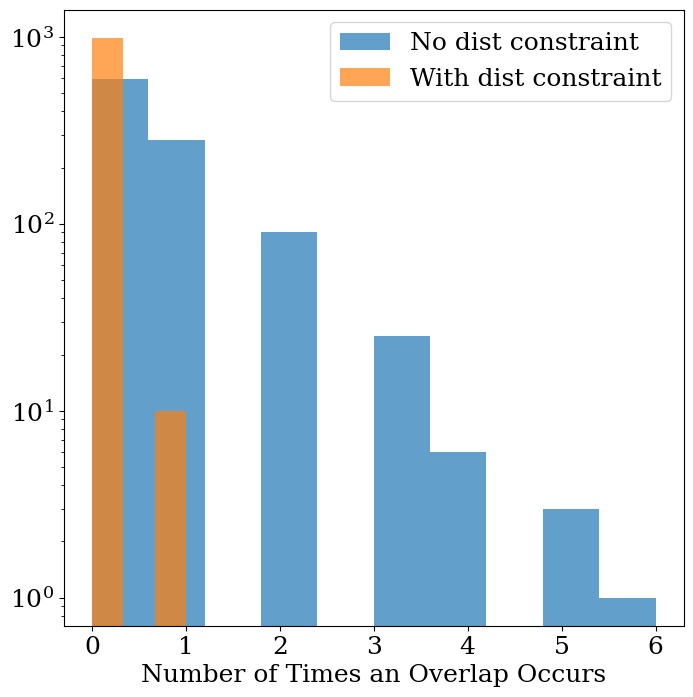

In [13]:
fig,ax = plt.subplots()

plt.hist(bh_overlaps_nodist, alpha=0.7, label='No dist constraint')
plt.hist(bh_overlaps,bins=3, alpha=0.7, label='With dist constraint')
plt.xlabel("Number of Times an Overlap Occurs")
plt.yscale("log")
plt.legend()

plt.show()

It is clear that the distance constraint reduces the number of times an overlap occurs. Now, how do we take these results and try to reflect them in a probability? There are several options. First, we could look solely at the number of overlaps and try to find a way to convey that information. We could look at the average number of overlaps per galaxy. This would give us the probability of a given galaxy having a situation where a BH would overlap with the central half of an SNR.

In [14]:
print("When there is no distance constraint:")
print(r"P$_{avg}$ $\pm$ $3 \sigma$ = %.3f $\pm$ %.3f" % (np.average(bh_overlaps_nodist),3*np.std(bh_overlaps_nodist)))

print("When there is a distance constraint:")
print(r"P$_{avg}$ $\pm$ $3 \sigma$ = %.3f $\pm$ %.3f" % (np.average(bh_overlaps),3*np.std(bh_overlaps )))

When there is no distance constraint:
P$_{avg}$ $\pm$ $3 \sigma$ = 0.580 $\pm$ 2.573
When there is a distance constraint:
P$_{avg}$ $\pm$ $3 \sigma$ = 0.010 $\pm$ 0.298


This tells us that the probability of a MW-type galaxy having a BH being coincident with the central half of an SNR is 50-60%. On the other hand, the probability of a MW-type galaxy having a BH coincident with the central half of an SNR where the BH is between 7.6 and 9.2 kpc away and the SNR is at least 7.5 kpc away, is ~1-2%. (This number is different every run, but if you increase the number of galaxies run to 10,000 then you will get consistent results every time.)

Second, we could look at the probability of a BH landing in the central half of an SNR. This means the **number of overlaps per galaxy divided by the number of BHs per galaxy. In other words, we are showing the probability that a specific BH is coincident with the central half of an SNR**. We are multiplying by 100 to get a percent.

(Note, we use the hpd() function below to get a 99.7% confidence interval because the function is very skewed and the data has more precise values. But we used np.average and np.std above because if I use hpd(bh_prob, 0.997), it just gives me a range of (0,1). So, using np.average and np.std conveys convey the number of overlaps per galaxy better.)

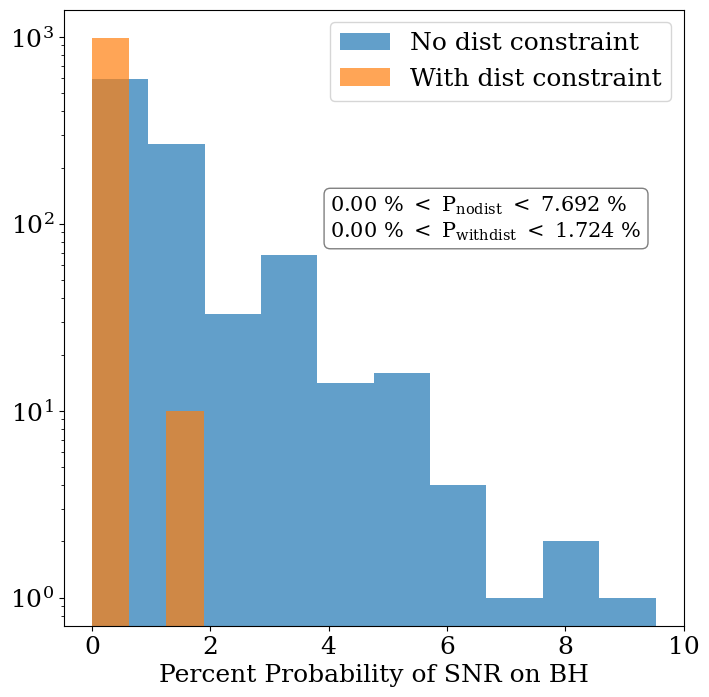

In [15]:
#getting probability of BH overlapping with central half of SNR
prob_nodist_SNR_on_BH = bh_overlaps_nodist*100/BH_count_nodist
prob_SNR_on_BH = bh_overlaps*100/BH_count

#just plotting
fig,ax = plt.subplots()

plt.hist(prob_nodist_SNR_on_BH, alpha=0.7, label='No dist constraint')
plt.hist(prob_SNR_on_BH, bins=3,alpha=0.7, label='With dist constraint')
plt.xlabel("Percent Probability of SNR on BH")
plt.yscale("log")
plt.legend()

textstr = '\n'.join((r"$%.2f$ %% $<$ P$_{\rm{no dist}}$ $<$ $%.3f$ %% " % (hpd(prob_nodist_SNR_on_BH, 0.997)[0],hpd(prob_nodist_SNR_on_BH, 0.997)[1] ),
                     r"$%.2f$ %% $<$ P$_{\rm{with dist}}$ $<$ $%.3f$ %%" % (hpd(prob_SNR_on_BH, 0.997)[0],hpd(prob_SNR_on_BH, 0.997)[1]) ))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box
ax.text(0.43, 0.7, textstr, fontsize=15, transform=ax.transAxes,verticalalignment='top', bbox=props)

plt.show()

OR we can look at the **probability of a given SNR containing a BH in its central half. This is the number of overlaps per galaxy divided by the number of SNRs per galaxy.** Statistics wise, this is different from the probability of a given BH being coincident with the central half of an SNR (num_overlaps/num_BHs), and different from the probability of a BH in a central half of an SNR existing in the galaxy (average of num_overlaps).

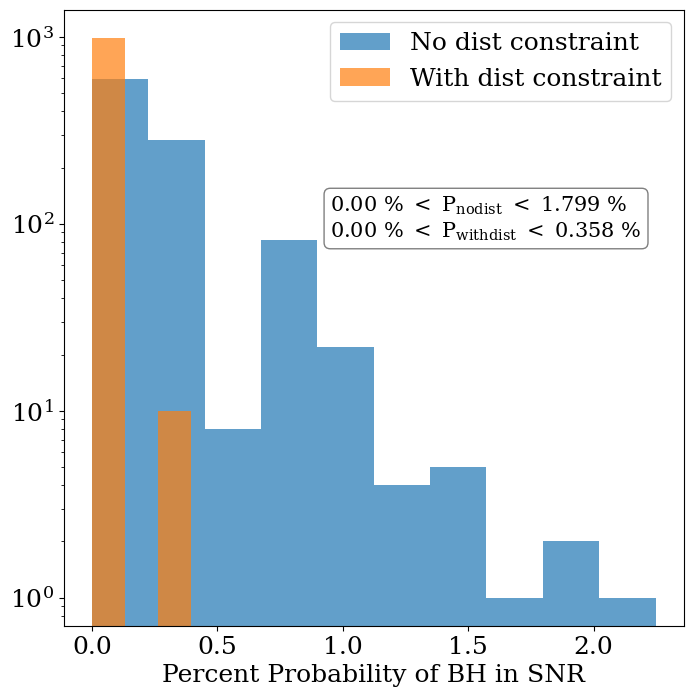

In [16]:
#getting probability of SNR's central half having a BH
prob_nodist_BH_in_SNR = bh_overlaps_nodist*100/SNR_count_nodist
prob_BH_in_SNR = bh_overlaps*100/SNR_count


fig,ax = plt.subplots()

plt.hist(prob_nodist_BH_in_SNR, alpha=0.7, label='No dist constraint')
plt.hist(prob_BH_in_SNR, bins=3,alpha=0.7, label='With dist constraint')
plt.xlabel("Percent Probability of BH in SNR")
plt.yscale("log")
plt.legend()

textstr = '\n'.join((r"$%.2f$ %% $<$ P$_{\rm{no dist}}$ $<$ $%.3f$ %% " % (hpd(prob_nodist_BH_in_SNR, 0.997)[0],hpd(prob_nodist_BH_in_SNR, 0.997)[1] ),
                     r"$%.2f$ %% $<$ P$_{\rm{with dist}}$ $<$ $%.3f$ %%" % (hpd(prob_BH_in_SNR, 0.997)[0],hpd(prob_BH_in_SNR, 0.997)[1]) ))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box
ax.text(0.43, 0.7, textstr, fontsize=15, transform=ax.transAxes,verticalalignment='top', bbox=props)

plt.show()

The probability of finding a BH in the central half of the SNR is higher than the probability that a given BH overlaps with the central half of a SNR. This is why I've been struggling to clearly convey the "probability of overlap". Effectively, there are three ways to convey the probability: some average of num_overlaps OR num_overlaps/num_BHs or num_overlaps/num_SNRs.


**Now, let's look at the effect of the number of objects in the simulation.** If we increase the number of SNRs by 5,

In [17]:
''' Changing the number of objects...'''
BH_factor = 1
SNR_factor = 5

'''
now the actual number of samples, calculated using trial and error and the above num_samples_needed function
'''

numsamps_SNR_ls, numsamps_SNR_bs = 1506*SNR_factor, 7005*SNR_factor
numsamps_SNR_heights, numsamps_SNR_widths, numsamps_SNR_dists = 4329*SNR_factor, 3429*SNR_factor, 3531*SNR_factor
numsamps_BH_ls, numsamps_BH_bs = 1473*BH_factor,712*BH_factor
numsamps_BH_dists = 594*BH_factor


In [18]:
''' 
d=4 means an overlap only occurs if the BH is in the central half of the remnant 
'''
d = 4

#initializing
num_galaxies = 1000 #number of galaxies to simulate
run_nums = 0
start = time.time()
bh_overlaps_nodist, SNR_count_nodist, BH_count_nodist = [],[],[]

'''
The number of runs here means indicates the number of Milky Way-like galaxies being sampled. In the paper,
we simulate 10000.

In each galaxy we simulate a population and calculate the number of overlaps. We append the 
number of overlaps to our bh_overlap array.
'''
while run_nums < num_galaxies:
    SNRs, BHs = simulate_populations() #simulate a MW-like population
    bh_overlaps_nodist.append(count_overlaps(SNRs, BHs))#counting the overlaps in that population and recording it
    SNR_count_nodist.append(len(SNRs[0])) #recording number of SNRs generated
    BH_count_nodist.append(len(BHs[0])) #recording number of BHs generated
    
    #the code below just lets us keep track of how many runs the code has run
    if (run_nums%200) == 0:
        print("Simulated %.0i SNRs and %.0i BHs." % (len(SNRs[0]), len(BHs[0])) )
        print("Done with "+str(run_nums)+" rounds")
        print("So far time is", time.time()-start)
        print(" ")
    run_nums += 1
    run_nums += 1
print("Total time taken is", time.time()-start)
bh_overlaps_nodist, SNR_count_nodist, BH_count_nodist= np.array(bh_overlaps_nodist), np.array(SNR_count_nodist), np.array(BH_count_nodist)


Simulated 1387 SNRs and 72 BHs.
Done with 0 rounds
So far time is 0.09625720977783203
 
Simulated 1383 SNRs and 65 BHs.
Done with 200 rounds
So far time is 7.382264137268066
 
Simulated 1376 SNRs and 65 BHs.
Done with 400 rounds
So far time is 15.230800151824951
 
Simulated 1406 SNRs and 69 BHs.
Done with 600 rounds
So far time is 22.701174020767212
 
Simulated 1380 SNRs and 65 BHs.
Done with 800 rounds
So far time is 30.244985103607178
 
Total time taken is 37.5692412853241


In [19]:
''' 
d=4 means an overlap only occurs if the BH is in the central half of the remnant 
'''
d = 4

dist_BH_low, dist_BH_high = 7.6,9.2
dist_SNR = 7.5

#initializing
num_galaxies = 1000 #number of galaxies to simulate
run_nums = 0
start = time.time()
bh_overlaps, SNR_count, BH_count = [], [], []

'''
The number of runs here means indicates the number of Milky Way-like galaxies being sampled. In the paper,
we simulate 10000.

In each galaxy we simulate a population and calculate the number of overlaps. We append the 
number of overlaps to our bh_overlap array.
'''
while run_nums < num_galaxies:
    SNRs, BHs = simulate_populations_withdist() #simulating a population
    bh_overlaps.append(count_overlaps_withdist(SNRs, BHs)) #counting the overlaps in that population and recording it
    SNR_count.append(len(SNRs[0])) #recording number of SNRs generated
    BH_count.append(len(BHs[0])) #recording number of BHs generated
    
    #the code below just lets us keep track of how many runs the code has run
    if (run_nums%200) == 0:
        print("Simulated %.0i SNRs and %.0i BHs." % (len(SNRs[0]), len(BHs[0])) )
        print("Done with "+str(run_nums)+" rounds")
        print("So far time is", time.time()-start)
    run_nums += 1
    
print("Total time taken is", time.time()-start)

bh_overlaps, SNR_count, BH_count = np.array(bh_overlaps), np.array(SNR_count), np.array(BH_count)


Simulated 1427 SNRs and 64 BHs.
Done with 0 rounds
So far time is 0.02812504768371582
Simulated 1384 SNRs and 64 BHs.
Done with 200 rounds
So far time is 4.930866241455078
Simulated 1467 SNRs and 55 BHs.
Done with 400 rounds
So far time is 9.793483972549438
Simulated 1444 SNRs and 58 BHs.
Done with 600 rounds
So far time is 14.6755051612854
Simulated 1470 SNRs and 69 BHs.
Done with 800 rounds
So far time is 19.54631018638611
Total time taken is 24.43329906463623


**Repeating everything we did earlier, we end up with:**

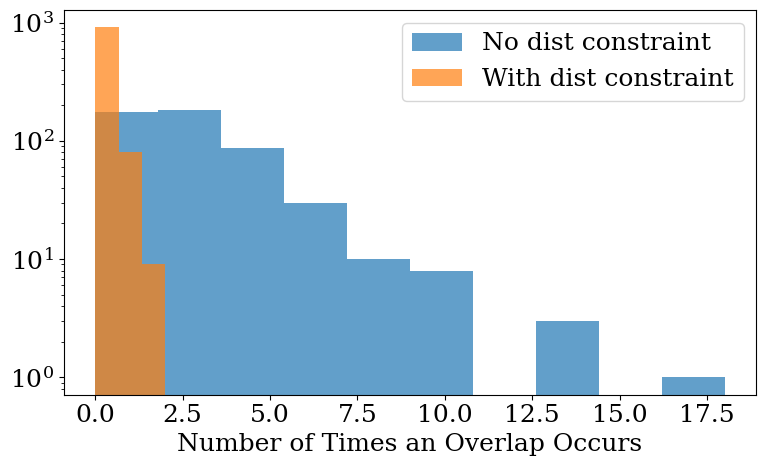

In [20]:
fig,ax = plt.subplots(1,1,figsize=(8,5)) 

ax.hist(bh_overlaps_nodist, alpha=0.7, label='No dist constraint')
ax.hist(bh_overlaps,bins=3, alpha=0.7, label='With dist constraint')
ax.set_xlabel("Number of Times an Overlap Occurs")
ax.set_yscale("log")
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
print("When there is no distance constraint:")
print(r"P$_{avg}$ $\pm$ $3 \sigma$ = %.3f $\pm$ %.3f" % (np.average(bh_overlaps_nodist),3*np.std(bh_overlaps_nodist)))
print(" ")
print("When there is a distance constraint:")
print(r"P$_{avg}$ $\pm$ $3 \sigma$ = %.3f $\pm$ %.3f" % (np.average(bh_overlaps),3*np.std(bh_overlaps )))

When there is no distance constraint:
P$_{avg}$ $\pm$ $3 \sigma$ = 2.684 $\pm$ 7.038
 
When there is a distance constraint:
P$_{avg}$ $\pm$ $3 \sigma$ = 0.098 $\pm$ 0.979


Now, the average number of overlaps is much higher.

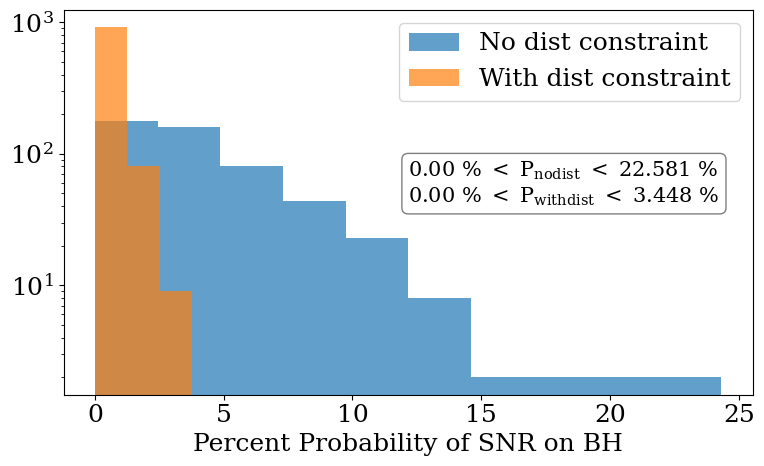

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,5)) 

prob_nodist_SNR_on_BH = bh_overlaps_nodist*100/BH_count_nodist
prob_SNR_on_BH = bh_overlaps*100/BH_count


ax.hist(prob_nodist_SNR_on_BH, alpha=0.7, label='No dist constraint')
ax.hist(prob_SNR_on_BH, bins=3,alpha=0.7, label='With dist constraint')
ax.set_xlabel("Percent Probability of SNR on BH")
ax.set_yscale("log")
ax.legend()

textstr2 = '\n'.join((r"$%.2f$ %% $<$ P$_{\rm{no dist}}$ $<$ $%.3f$ %% " % (hpd(prob_nodist_SNR_on_BH, 0.997)[0],hpd(prob_nodist_SNR_on_BH, 0.997)[1] ),
                      r"$%.2f$ %% $<$ P$_{\rm{with dist}}$ $<$ $%.3f$ %%" % (hpd(prob_SNR_on_BH, 0.997)[0],hpd(prob_SNR_on_BH, 0.997)[1]) ))

# place a text box in upper left in axes coords
ax.text(0.5,0.5, textstr2, fontsize=15, transform=ax.transAxes, bbox=props)

plt.tight_layout()
plt.show()


These probabilities have increased by a factor of 5.

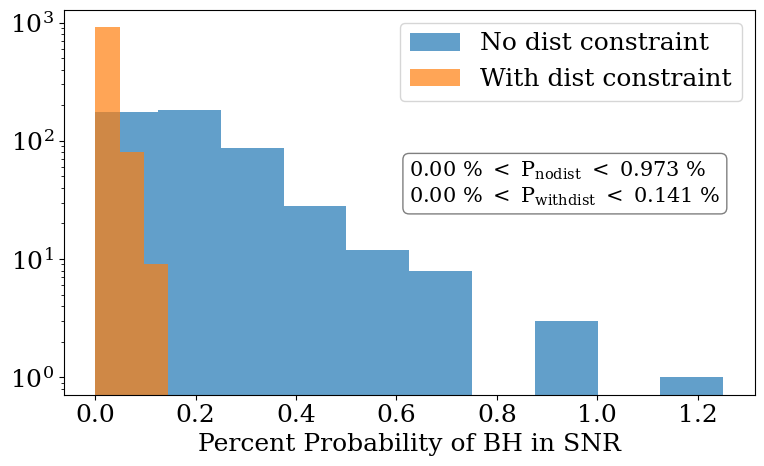

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,5)) 

prob_nodist_BH_in_SNR = bh_overlaps_nodist*100/SNR_count_nodist
prob_BH_in_SNR = bh_overlaps*100/SNR_count


ax.hist(prob_nodist_BH_in_SNR, alpha=0.7, label='No dist constraint')
ax.hist(prob_BH_in_SNR, bins=3,alpha=0.7, label='With dist constraint')
ax.set_xlabel("Percent Probability of BH in SNR")
ax.set_yscale("log")
ax.legend()

textstr3 = '\n'.join((r"$%.2f$ %% $<$ P$_{\rm{no dist}}$ $<$ $%.3f$ %% " % (hpd(prob_nodist_BH_in_SNR, 0.997)[0],hpd(prob_nodist_BH_in_SNR, 0.997)[1] ),
                      r"$%.2f$ %% $<$ P$_{\rm{with dist}}$ $<$ $%.3f$ %%" % (hpd(prob_BH_in_SNR, 0.997)[0],hpd(prob_BH_in_SNR, 0.997)[1]) ))


# place a text box in upper left in axes coords
ax.text(0.5,0.5, textstr3, fontsize=15, transform=ax.transAxes, bbox=props)

plt.tight_layout()
plt.show()

This number hasn't really gone up. This is because increasing the number of SNRs increases the number of overlaps, but really increases the number of SNRs. If I change it such that there are 5x more BHs and 2x more SNRs, then this probability increases.

You may say, "Hey! In the paper, there is a plot where the probability increased when you use ~5x SNRs!". Well, I have regrettably discovered that while 10k galaxies is enough to get consistent results when running ~300 SNRs and ~60 BHs, it is not enough to get consistent results with ~1500 SNRs. To get consistent results, I had to run 100k galaxies. (I think, I only did it like 3 times.)